In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
import math
import pickle

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.util import view_as_blocks
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

#VIS
from keras.utils.vis_utils import plot_model

In [2]:
base_dir = '/Users/hamnamoieez/Desktop/PRDL/Distracted-Driver-Detection-Using-Deep-Learning/'
train_imgs = base_dir + "imgs/train/"
concept_path = base_dir + "concept_images/"
concept_imgs = base_dir + "concept_imgs/"
test_imgs =  os.path.join(base_dir, 'imgs/test/')
weights_path = os.path.join(base_dir, 'weights/')
class_mapper = {0: "safe driving",
                1: "texting - right",
                2: "talking on the phone - right",
                3: "texting - left",
                4: "talking on the phone - left",
                5: "operating the radio",
                6: "drinking",
                7: "reaching behind",
                8: "hair and makeup",
                9: "talking to passenger"}

In [3]:
train_imgs_path_holder = {}
for img_path in glob(concept_path + "*/*.jpg"):
    class_name = img_path.split("/")[-2]
    if class_name not in train_imgs_path_holder.keys():
        train_imgs_path_holder[class_name] = []
        train_imgs_path_holder[class_name].append(img_path)
    else:
        train_imgs_path_holder[class_name].append(img_path)

In [4]:
train_imgs_path_holder.keys()

dict_keys(['hair and makeup during driving', 'drinking water during driving', 'talking on the phone during driving', 'operating the radio during driving', 'texting during driving', 'talking to passenger during driving', 'reaching behind during driving'])

In [6]:
# safe_driving = train_imgs_path_holder["c0"]
# texting_right = train_imgs_path_holder["c1"]
talking_on_the_phone_right = train_imgs_path_holder["talking on the phone during driving"]
texting_left = train_imgs_path_holder["texting during driving"]
# talking_on_the_phone_left = train_imgs_path_holder["c4"]

operating_the_radio = train_imgs_path_holder["operating the radio during driving"]
drinking = train_imgs_path_holder["drinking water during driving"]
reaching_behind = train_imgs_path_holder["reaching behind during driving"]
hair_makeup = train_imgs_path_holder["hair and makeup during driving"]
talking_to_passenger = train_imgs_path_holder["talking to passenger during driving"]

In [7]:
classes = {"talking_on_the_phone_right": talking_on_the_phone_right,
          "texting_left": texting_left,
          "operating_the_radio": operating_the_radio,
          "drinking": drinking,
          "reaching_behind": reaching_behind,
          "hair_makeup": hair_makeup,
          "talking_to_passenger": talking_to_passenger}

In [8]:
def extract_patches(img, patch_size, to_save_dir, img_id):
    sub_level_counter = 0
    patches = extract_patches_2d(img, patch_size)
    total_patches = 0
    for ix, patch in enumerate(patches):
        if ix % 10 == 0:
            sub_level_counter += 1
            if sub_level_counter % 5 == 0:
                plt.imsave(f'{to_save_dir}' + f'{img_id}_{total_patches}.jpg', patch)
                total_patches += 1

In [9]:
take_random = 10
patch_width, patch_height = 112, 112
for cls_name, img_paths in classes.items():
    print(f"For Class {cls_name}!")
    to_save_dir = concept_imgs + f"{cls_name}/"
    os.makedirs(to_save_dir, exist_ok = True)
    random_paths = np.random.choice(img_paths, 10)
    for img_id, img in enumerate(random_paths):
        whole_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), (224, 224))
        img_height, img_width, _ = whole_img.shape
        extract_patches(whole_img, (patch_width, patch_height), to_save_dir, img_id)

For Class talking_on_the_phone_right!
For Class texting_left!
For Class operating_the_radio!
For Class drinking!
For Class reaching_behind!
For Class hair_makeup!
For Class talking_to_passenger!


In [7]:
def predict_concept(concept_img, model):
    test = image.load_img(concept_img, target_size=(112, 112))
    img_array = image.img_to_array(test)
    img_batch = np.expand_dims(img_array, axis=0)
    img = np.vstack([img_batch])
    feature_layer = keras.models.Model(inputs=model.input, outputs=model.get_layer('features').output)
    prediction = feature_layer.predict(img)
    preds = prediction.flatten()
    return preds

In [8]:
model = keras.models.load_model(weights_path+'_model.h5')

In [12]:
concept_dict = {}
for img_path in glob(concept_imgs + "*/*.jpg"):
    img_name = img_path.split("/")[-1]
    concept_class = img_path.split("/")[-2]
    features = predict_concept(img_path, model)
    if concept_class not in concept_dict.keys():
        concept_dict[concept_class] = []
        concept_dict[concept_class].append(features)
    else:
        concept_dict[concept_class].append(features)

In [13]:
print(len(concept_dict))

7


In [14]:
with open('concepts.pickle', 'wb') as handle:
    pickle.dump(concept_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('concepts.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [24]:
print(b.keys())

dict_keys(['talking_to_passenger', 'talking_on_the_phone_left', 'hair_makeup', 'texting_right', 'talking_on_the_phone_right', 'operating_the_radio', 'drinking', 'texting_left', 'reaching_behind', 'safe_driving'])


In [ ]:
class_pred =np.argmax(prediction,axis=1)
print(class_pred)

In [31]:
predicted_class_name = [class_mapper[k] for k in class_pred]
print(predicted_class_name[0])

talking to passenger


In [5]:
class_map = {"c0":"safe_driving",
          "c1":"texting_right",
          "c2":"talking_on_the_phone_right",
          "c3":"texting_left",
          "c4":"talking_on_the_phone_left",
          "c5":"operating_the_radio",
          "c6":"drinking",
          "c7":"reaching_behind",
          "c8":"hair_makeup",
          "c9":"talking_to_passenger"}

In [18]:
img_dict = {}
for img_path in glob(train_imgs + "*/"):
    for img in glob(img_path +"*.jpg")[:30]:
        img_name = img.split("/")[-1]
        img_class = class_map[img_path.split("/")[-2]]
        feat = predict_concept(img, model)
        if img_class not in img_dict.keys():
            img_dict[img_class] = []
            img_dict[img_class].append(feat)
        else:
            img_dict[img_class].append(feat)

In [28]:
with open('images.pickle', 'wb') as handle:
    pickle.dump(img_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# TSNE

In [19]:
tsne_lab = []
tsne_feat = []
for img_path in glob(train_imgs + "*/"):
    for img in glob(img_path +"*.jpg")[:500]:
        img_name = img.split("/")[-1]
        img_class = class_map[img_path.split("/")[-2]]
        feat = predict_concept(img, model)
        tsne_lab.append(img_class)
        tsne_feat.append(feat)

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
transform = tsne.fit_transform(tsne_feat)

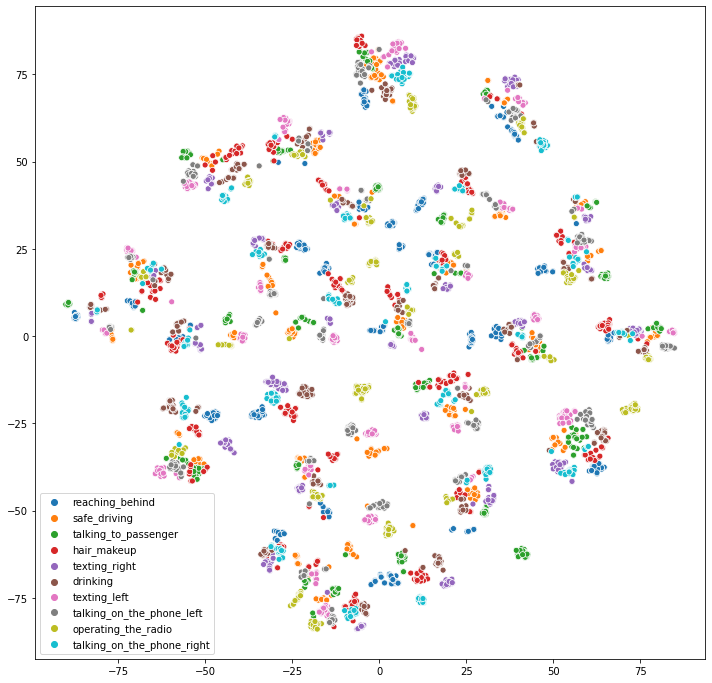

In [21]:
import seaborn as sns
plt.figure(figsize=(12,12))
sns.scatterplot(x=transform[:,0], y=transform[:,1], hue=tsne_lab)
plt.savefig('tsne.png', dpi=100, bbox_inches='tight')